<a href="https://colab.research.google.com/github/damoon843/al-gore-ithms/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import defaultdict
import json
import pandas as pd 
import numpy as np 
import requests 
import datetime
from bs4 import BeautifulSoup
import statsmodels.api as sm
from statsmodels.tools import eval_measures
import copy

# Text processing imports
import spacy
parser = spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Visualization imports
import matplotlib.pyplot as plt

# Statistical test imports
import scipy
import statsmodels
from scipy.stats import friedmanchisquare
from statsmodels.graphics.gofplots import qqplot

# DATA DELIVERABLE (CHECKPOINT 1)

## CONSTRUCT THE DATASET

In [ ]:

# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

# Dataset from: https://www.whitehouse.gov/omb/historical-tables/
# NOTE: make sure the shared projet folder follows this path
with open('/content/drive/My Drive/CS1951A Final Project/hist05z2_fy22.csv', 'r', encoding='utf-8') as data:
  budget_df = pd.read_csv(data, header=2, index_col="Department or other unit")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
budget_df.head(4)

,1976,TQ,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021 estimate,2022 estimate,2023 estimate,2024 estimate,2025 estimate,2026 estimate
Department or other unit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Legislative Branch,936,226,"1,057","1,087","1,131","1,318","1,251","1,414","1,687","1,768","1,703","1,720","1,873","2,123","2,250","2,248","2,493","2,632","2,621","2,612","2,682","2,454","2,541","2,627","2,943","2,800","3,149","3,613","3,830","3,937","4,036","4,219","4,286","4,447","4,977","4,893","4,737","4,542","4,258","4,462","4,506","4,570","4,686","4,981","5,061","5,376","5,628","6,147","6,288","6,421","6,544","6,685"
Judicial Branch,346,87,431,459,521,609,656,733,823,904,"1,055","1,045","1,273","1,344","1,481","1,752","2,118","2,445","2,613","2,832","2,998","3,174","3,386","3,543","3,807","4,067","4,459","4,970","5,168","5,440","5,726","5,993","6,180","6,518","6,787","7,214","7,205","7,240","6,926","7,284","7,404","7,596","7,760","7,908","8,134","8,413","8,610","9,161","9,341","9,550","9,762","9,960"
Department of Agriculture,"20,690","4,233","21,841","26,659","37,250","39,559","47,410","57,400","69,831","46,734","61,823","59,154","52,421","55,134","55,627","55,214","59,957","66,170","67,730","65,458","58,437","58,592","60,727","58,134","67,560","75,162","73,082","71,209","78,750","93,037","95,023","97,339","91,821","92,950","127,826","130,983","140,677","151,789","154,924","157,510","142,471","168,801","136,547","142,537","166,709","235,204","261,119","249,259","170,951","173,031","173,829","174,009"
Department of Commerce,"1,732",357,"7,814","1,892","2,086","2,610","2,072","1,834","1,923","2,015","2,309","1,980","2,155","2,449","2,807","3,683","2,648","3,022","3,159","3,811","4,025","3,612","3,758","4,100","5,431","8,733","5,167","5,545","5,800","5,877","6,476","6,638","7,766","9,585","25,713","13,679","5,704","7,978","7,959","10,113","13,817","10,351","9,486","18,269","12,520","17,388","14,308","80,257","25,133","37,396","25,717","20,178"


In [ ]:
# Webscrape State of The Union Addresses
# Dataset from: https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union

speech_table_url = "https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union"
def get_yearly_speeches():
    response = requests.get(speech_table_url, auth=('user', 'pass'))
    # print("response: ", response, type(response))
    # print("response.text: ", response.text, type(response.text))
    html_dump = BeautifulSoup(response.text, 'html.parser')

    # list of all the things with the lable "table"
    html_tables = html_dump.find('table')
    cols = html_tables.find("tbody")
    all_speeches_url = []
    speeches = cols.find_all("tr")
    # print(stocks)
    for i in speeches:
        entry = i.find_all("td")
        for j in entry:
          potential_link = j.a
          # print(potential_link)
          if type(j.text.strip()) is str and len(j.text.strip()) > 9:
            president = j.text.strip().lower()
            # print("name = ",j.text.strip().lower())
          elif potential_link is not None:
            year = potential_link.text
            url = potential_link['href']
            # print(potential_link.text, potential_link['href'])
            all_speeches_url.append({"president": president, "year":year, "url": url})
    return all_speeches_url
all_speeches_url = get_yearly_speeches()
print(all_speeches_url)

[{'president': '2021-present', 'year': '2021', 'url': 'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-3'}, {'president': 'donald j. trump', 'year': '2017', 'url': 'https://www.presidency.ucsb.edu/ws/index.php?pid=123408'}, {'president': 'donald j. trump', 'year': '2018', 'url': 'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-25'}, {'president': 'donald j. trump', 'year': '2019', 'url': 'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-26'}, {'president': 'donald j. trump', 'year': '2020', 'url': 'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-27'}, {'president': 'barack obama', 'year': '2013', 'url': 'https://www.presidency.ucsb.edu/ws/index.php?pid=102826'}, {'president': 'barack obama', 'year': '2014', 'url': 'https://www.presidency.ucsb.edu/ws/index.php?pid=104596'}, {'president':

In [ ]:
for speech in all_speeches_url:
  # print(speech['president'])
  if(speech['president'] == 'gerald r. ford'):
    break
  response = requests.get(speech['url'])
  html_dump = BeautifulSoup(response.text, 'html.parser')
  # cols = html_tables.find("tbody")
  stocks = html_dump.find_all("section")
  full_text_together = ""
  for i in stocks:
    full_text_broken = i.find_all("p")
    # print("text", full_text_broken)
    for j in full_text_broken:
      # print("text", full_text)
      full_text_together += j.text + " "
      speech['speech'] = (full_text_together)
# print(all_speeches_url)

In [ ]:
# Convert to pandas DF
speeches_df = pd.DataFrame(all_speeches_url)
speeches_df.head(48)

,president,year,url,speech
0,2021-present,2021,https://www.presidency.ucsb.edu/documents/addr...,About Search The President. Thank you. Thank ...
1,donald j. trump,2017,https://www.presidency.ucsb.edu/ws/index.php?p...,About Search Thank you very much. Mr. Speaker...
2,donald j. trump,2018,https://www.presidency.ucsb.edu/documents/addr...,"About Search The President. Mr. Speaker, Mr. ..."
3,donald j. trump,2019,https://www.presidency.ucsb.edu/documents/addr...,"About Search The President. Madam Speaker, Mr..."
4,donald j. trump,2020,https://www.presidency.ucsb.edu/documents/addr...,About Search The President. Thank you very mu...
5,barack obama,2013,https://www.presidency.ucsb.edu/ws/index.php?p...,"About Search Please, everybody, have a seat. ..."
6,barack obama,2014,https://www.presidency.ucsb.edu/ws/index.php?p...,"About Search The President. Mr. Speaker, Mr. ..."
7,barack obama,2015,https://www.presidency.ucsb.edu/ws/index.php?p...,"About Search The President. Mr. Speaker, Mr. ..."
8,barack obama,2016,https://www.presidency.ucsb.edu/ws/index.php?p...,"About Search Thank you. Mr. Speaker, Mr. Vice..."
9,barack obama,2009,https://www.presidency.ucsb.edu/ws/index.php?p...,"About Search Madam Speaker, Mr. Vice Presiden..."


Load in health dictionary dataset

In [ ]:
with open('/content/drive/My Drive/CS1951A Final Project/health_dictionary.txt', 'r', encoding='utf-8') as data:
  items =  data.readlines()
  health_dic = [x.strip().lower() for x in items] 
print(health_dic)

print(len(health_dic))

['disease', 'epidemiology', 'epidemiologic', 'health', 'health care provider', 'health care setting', 'health disparities', 'immune system', 'immunization', 'incidence rate', 'incubation period', 'medical facilities', 'medication', 'public health', 'respiratory', 'risk assessment', 'risk factor', 'screening', 'toxic', 'toxigenic', 'transmit,', 'transmission', 'vaccine', 'virus', 'bioterrorism', 'chronic disease', 'clinical services', 'personal medical services', 'determinants of health', 'disease management', 'endemic', 'epidemic', 'epidemiology', 'infant mortality rate', 'infectious', 'morbidity', 'mortality', 'non-infectious', 'primary medical care', 'quarantine', 'screening', 'state health agency', 'years of potential life lost', 'primary care', 'self-care', 'basic health services', 'health care worker', 'comprehensive health system', 'essential drugs', 'health insurance', 'coinsurance', 'copayment', 'cost sharing', 'diagnostic test', 'emergency medical condition', 'emergency servic

# CLEAN AND PROCESS DATA

In [ ]:
# Filter budget_df and transform strings to floats
health_budget_df = budget_df.loc[['Department of Health and Human Services', 'Total budget authority']]
health_budget_df.loc['Department of Health and Human Services'] = health_budget_df.loc['Department of Health and Human Services'].apply(lambda x: float(x.split()[0].replace(',', '')))
health_budget_df.loc['Total budget authority'] = health_budget_df.loc['Total budget authority'].apply(lambda x: float(x.split()[0].replace(',', '')))

# Transform budget_df into percentage (dept of health & human services / total budget authority)
percent_health_budget_series = pd.Series(health_budget_df.loc['Department of Health and Human Services'].divide(health_budget_df.loc['Total budget authority']), name='Percent health budget spend')
transformed_health_budget_df = health_budget_df.append(percent_health_budget_series)

# Drop columns past 2020 (speeches dataset until 2020) and TQ
transformed_health_budget_df = transformed_health_budget_df.drop(labels=['TQ', '2021 estimate', '2022 estimate', '2023 estimate', '2024 estimate', '2025 estimate', '2026 estimate'], axis=1)

transformed_health_budget_df

,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Department or other unit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Department of Health and Human Services,40368,47035,51891,59726,70002,80788,86307,91478,103715,113981,123589,133443,142396,155160,184673,201473,251439,257702,307700,301969,318434,353652,359307,364973,392122,434443,478236,515464,556305,591392,684554,658365,721693,851721,889608,889186,874458,873330,960955,1.04516e+06,1.11901e+06,1.14401e+06,1.17636e+06,1.28398e+06,1.72136e+06
Total budget authority,420870,468450,504565,558829,670062,740300,806522,869841,923384,1.02825e+06,1.01393e+06,1.03301e+06,1.09131e+06,1.19589e+06,1.28616e+06,1.38606e+06,1.46739e+06,1.47433e+06,1.52920e+06,1.53965e+06,1.58091e+06,1.64278e+06,1.69215e+06,1.77666e+06,1.82487e+06,1.95887e+06,2.09001e+06,2.26606e+06,2.40818e+06,2.58264e+06,2.7804e+06,2.86307e+06,3.32628e+06,4.07748e+06,3.4846e+06,3.50988e+06,3.57616e+06,3.47837e+06,3.61898e+06,3.7727e+06,3.97293e+06,4.15381e+06,4.46572e+06,4.7028e+06,7.7353e+06
Percent health budget spend,0.0959156,0.100406,0.102843,0.106877,0.104471,0.109129,0.107011,0.105166,0.112321,0.110849,0.121891,0.129179,0.130482,0.129744,0.143584,0.145356,0.171351,0.174792,0.201216,0.196128,0.201424,0.215277,0.212337,0.205426,0.214877,0.221782,0.22882,0.227472,0.231007,0.228987,0.246207,0.229951,0.216967,0.208884,0.255297,0.253338,0.244524,0.251075,0.265532,0.277034,0.281657,0.275413,0.263421,0.273024,0.222534


In [ ]:
print(f"Raw budget df shape: {budget_df.shape}")
print(f"Health budget df shape: {transformed_health_budget_df.shape}")

Raw budget df shape: (36, 52)
Health budget df shape: (3, 45)


In [ ]:
print(f"Raw number of speeches: {speeches_df.shape}")
print(f"Raw number of Presidents: {speeches_df.groupby(by=['president'] , axis=0).count()['speech']}")

print(speeches_df[speeches_df['president'] == 'gerald r. ford'])

# Drop N/A rows in speeches data
speeches_df_filtered = speeches_df.dropna(axis=0, subset=['speech'])
# Removes "about search"
speeches_df_filtered["speech"] = speeches_df_filtered["speech"].apply(lambda x: x[14:])

# Filter out Joe Biden from dataframe (see reasoning in write-up)
speeches_df_filtered = speeches_df_filtered[speeches_df_filtered['president'] != '2021-present']

print(f"Transformed number of speeches: {speeches_df_filtered.shape}")
print(f"Transformed number of Presidents: {speeches_df_filtered.groupby(by=['president'] , axis=0).count()['speech']}")

Raw number of speeches: (242, 4)
Raw number of Presidents: president
2021-present             1
abraham lincoln          0
andrew jackson           0
andrew johnson           0
barack obama             8
benjamin harrison        0
calvin coolidge          0
chester a. arthur        0
donald j. trump          4
dwight d. eisenhower     0
franklin d. roosevelt    0
franklin pierce          0
george bush              4
george w. bush           8
george washington        0
gerald r. ford           0
grover cleveland         0
harry s truman           0
herbert hoover           0
james buchanan           0
james k. polk            0
james madison            0
james monroe             0
jimmy carter             7
john adams               0
john f. kennedy          0
john quincy adams        0
john tyler               0
lyndon b. johnson        0
martin van buren         0
millard fillmore         0
richard m. nixon         0
ronald reagan            8
rutherford b. hayes      0
theodore roos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
# Include partisanship for each president
conditions = [
              speeches_df_filtered['president'] == 'donald j. trump',
              speeches_df_filtered['president'] == 'barack obama',
              speeches_df_filtered['president'] == 'george w. bush',
              speeches_df_filtered['president'] == 'william j. clinton',
              speeches_df_filtered['president'] == 'george bush',
              speeches_df_filtered['president'] == 'ronald reagan',
              speeches_df_filtered['president'] == 'jimmy carter',
]

is_dem = ['False', 'True', 'False', 'True', 'False', 'False', 'True']
speeches_df_filtered['is_democrat'] = np.select(conditions, is_dem)

speeches_df_filtered.head()

,president,year,url,speech,is_democrat
1,donald j. trump,2017,https://www.presidency.ucsb.edu/ws/index.php?p...,"Thank you very much. Mr. Speaker, Mr. Vice Pre...",False
2,donald j. trump,2018,https://www.presidency.ucsb.edu/documents/addr...,"The President. Mr. Speaker, Mr. Vice President...",False
3,donald j. trump,2019,https://www.presidency.ucsb.edu/documents/addr...,"The President. Madam Speaker, Mr. Vice Preside...",False
4,donald j. trump,2020,https://www.presidency.ucsb.edu/documents/addr...,The President. Thank you very much. Thank you....,False
5,barack obama,2013,https://www.presidency.ucsb.edu/ws/index.php?p...,"Please, everybody, have a seat. Mr. Speaker, M...",True


In [ ]:
# Convert to text speeches to series
speeches_series = speeches_df_filtered['speech']
speeches_series.head(5)

1    Thank you very much. Mr. Speaker, Mr. Vice Pre...
2    The President. Mr. Speaker, Mr. Vice President...
3    The President. Madam Speaker, Mr. Vice Preside...
4    The President. Thank you very much. Thank you....
5    Please, everybody, have a seat. Mr. Speaker, M...
Name: speech, dtype: object

In [ ]:
# Customize tokenizer to remove '[' and ']'
suffixes = list(parser.Defaults.suffixes)
suffixes.remove("\]")
suffix_regex = spacy.util.compile_suffix_regex(suffixes)
parser.tokenizer.suffix_search = suffix_regex.search

prefixes = list(parser.Defaults.prefixes)
prefixes.remove("\[")
prefix_regex = spacy.util.compile_prefix_regex(prefixes)
parser.tokenizer.prefix_search = prefix_regex.search

# Run parser on all speeches to tokenize and create a list of spacy docs
parsed_speeches = []

for speech in speeches_series:    
  parsed_speeches.append(parser(speech))

In [ ]:
extra_stop_words = ['america', 'american', 'americans', 'government']

# Split str of words into list and lowercase
normalized_speeches = []

for speech in parsed_speeches:
  new_speech = []
  for w in speech:
      # Filter out words in between [], stop words, and puncutation
      if (
          not w.is_stop and not w.is_punct and not w.is_space and w.is_alpha and 
          (w.text[0] != '[' and w.text[-1] != ']') and 
          (w.lemma_.lower() not in extra_stop_words)
      ):
        # Lowercase before appending
        new_speech.append(w.lemma_.lower())
  
  normalized_speeches.append(new_speech)  

In [ ]:
print(normalized_speeches[0]) 

['thank', 'speaker', 'vice', 'president', 'members', 'congress', 'lady', 'united', 'states', 'citizen', 'tonight', 'mark', 'conclusion', 'celebration', 'black', 'history', 'month', 'remind', 'nation', 'path', 'civil', 'right', 'work', 'remain', 'recent', 'threat', 'target', 'jewish', 'community', 'center', 'vandalism', 'jewish', 'cemetery', 'week', 'shooting', 'kansas', 'city', 'remind', 'nation', 'divide', 'policy', 'country', 'stand', 'united', 'condemn', 'hate', 'evil', 'ugly', 'form', 'generation', 'pass', 'torch', 'truth', 'liberty', 'justice', 'unbroken', 'chain', 'way', 'present', 'torch', 'hand', 'use', 'light', 'world', 'tonight', 'deliver', 'message', 'unity', 'strength', 'message', 'deeply', 'deliver', 'heart', 'new', 'chapter', 'greatness', 'begin', 'new', 'national', 'pride', 'sweep', 'nation', 'new', 'surge', 'optimism', 'place', 'impossible', 'dream', 'firmly', 'grasp', 'witness', 'today', 'renewal', 'spirit', 'ally', 'find', 'ready', 'lead', 'nation', 'world', 'friend',

In [ ]:
speeches_df_filtered['speech'] = normalized_speeches

Join speech data and health budget data  
**For separate analyses, use speeches_df_filtered and transformed_health_budget_df**

In [ ]:
# Pivot health budget data to prepare for join
years = transformed_health_budget_df.columns.values
percentages = transformed_health_budget_df.iloc[2]
health_budget_dict = {years[i]: percentages[i] for i in range(len(years))}

pivoted_health_df = pd.DataFrame.from_dict(health_budget_dict, orient='index', columns=['percent health budget spend'])
pivoted_health_df.reset_index(inplace=True)
pivoted_health_df.rename(columns={'index':'year'}, inplace=True)
# pivoted_health_df.head()

# Perform merge
merged_df = pd.merge(speeches_df_filtered, pivoted_health_df, how='inner', on='year')
merged_df

,president,year,url,speech,is_democrat,percent health budget spend
0,donald j. trump,2017,https://www.presidency.ucsb.edu/ws/index.php?p...,"[thank, speaker, vice, president, members, con...",False,0.275413
1,donald j. trump,2018,https://www.presidency.ucsb.edu/documents/addr...,"[president, speaker, vice, president, members,...",False,0.263421
2,donald j. trump,2019,https://www.presidency.ucsb.edu/documents/addr...,"[president, madam, speaker, vice, president, m...",False,0.273024
3,donald j. trump,2020,https://www.presidency.ucsb.edu/documents/addr...,"[president, thank, thank, thank, madam, speake...",False,0.222534
4,barack obama,2013,https://www.presidency.ucsb.edu/ws/index.php?p...,"[everybody, seat, speaker, vice, president, me...",True,0.251075
5,barack obama,2014,https://www.presidency.ucsb.edu/ws/index.php?p...,"[president, speaker, vice, president, members,...",True,0.265532
6,barack obama,2015,https://www.presidency.ucsb.edu/ws/index.php?p...,"[president, speaker, vice, president, members,...",True,0.277034
7,barack obama,2016,https://www.presidency.ucsb.edu/ws/index.php?p...,"[thank, speaker, vice, president, members, con...",True,0.281657
8,barack obama,2009,https://www.presidency.ucsb.edu/ws/index.php?p...,"[madam, speaker, vice, president, members, con...",True,0.208884
9,barack obama,2010,https://www.presidency.ucsb.edu/ws/index.php?p...,"[madam, speaker, vice, president, biden, membe...",True,0.255297


# DEFINE TRAIN AND TEST SET


In [ ]:
from random import randrange

test_set_indices = []
president_array = np.unique(np.array(speeches_df_filtered['president']))
two_speeches = ['george bush', 'donald j. trump']

#selecting one speech from each president
for prez in president_array:
  prez_filtered = speeches_df_filtered[speeches_df_filtered["president"] == prez]
  speech_sampled = prez_filtered.sample()['speech']
  test_set_indices.append(speech_sampled.index[0])  # Subtract 1 b/c indices go from 1 to 47 (instead of 0 to 46)
  # test_speeches.append(prez_sampled[['president','speech','year']].values)

#getting randomly selected unique speeches
while len(test_set_indices) < 10:
  more_speeches = speeches_df_filtered[~speeches_df_filtered["president"].isin(two_speeches)]
  sample = more_speeches.sample()['speech']
  test_set_indices.append(int(sample.index[0]))

print(f"test set indices: {test_set_indices}")
test_set = merged_df.iloc[test_set_indices]
train_set = merged_df.drop(test_set_indices)
print(f"test set shape: {test_set.shape}")
print(f"train set shape: {train_set.shape}")


test set indices: [9, 1, 31, 15, 43, 34, 24, 40, 40, 37]
test set shape: (10, 6)
train set shape: (38, 6)


In [ ]:
# FILE DOWNLOAD FOR CHECKPOINT 1
# from google.colab import files

# with open('complete_speeches_data.csv', 'w') as f:
#   f.write(speeches_df_filtered.to_csv())

# with open('test_data.csv', 'w') as f:
#   for i in test_speeches.keys():
#     f.write("%s,%s\n"%(i,test_speeches[i]))

# with open('complete_budget_data.csv', 'w') as f:
#   f.write(transformed_health_budget_df.to_csv())

# files.download('complete_speeches_data.csv')
# files.download('test_data.csv')
# files.download('complete_budget_data.csv')

# EXPLORATORY ANALYSIS

### Topic Modeling
[Can we extract a health-related dimension using topic modelling?]


In [ ]:
# Convert each speech from list of strings to string
speeches = []
for speech in speeches_df_filtered["speech"]:
  speeches.append(" ".join(word for word in speech))

# Generate matrix of token counts
count_vec = CountVectorizer(lowercase=True, stop_words=None, ngram_range=(1,1))
doc_term_matrix = count_vec.fit_transform(speeches)
print(f"Number of documents: {doc_term_matrix.shape[0]}, Number of words {doc_term_matrix.shape[1]}")
print(f"Previewing first document:\n {doc_term_matrix[0]}")

# Build vocabulary
reverse_vocab_index = {j: i for i,j in count_vec.vocabulary_.items()} # Map to index:word

Number of documents: 47, Number of words 9075
Previewing first document:
   (0, 8116)	18
  (0, 7566)	4
  (0, 8753)	4
  (0, 6160)	12
  (0, 4980)	4
  (0, 1596)	18
  (0, 4498)	2
  (0, 8552)	26
  (0, 7692)	24
  (0, 1315)	22
  (0, 8223)	26
  (0, 4870)	2
  (0, 1556)	2
  (0, 1176)	4
  (0, 804)	2
  (0, 3729)	10
  (0, 5171)	6
  (0, 6707)	4
  (0, 5277)	42
  (0, 5775)	4
  (0, 1319)	4
  (0, 6917)	22
  (0, 8995)	24
  (0, 6698)	2
  (0, 6522)	4
  :	:
  (0, 7031)	2
  (0, 7187)	2
  (0, 4324)	2
  (0, 4266)	2
  (0, 7981)	2
  (0, 8103)	2
  (0, 2389)	2
  (0, 8352)	2
  (0, 107)	2
  (0, 4371)	2
  (0, 7264)	2
  (0, 5529)	2
  (0, 3355)	3
  (0, 5896)	2
  (0, 8992)	3
  (0, 6159)	4
  (0, 6257)	1
  (0, 5897)	1
  (0, 8395)	1
  (0, 2909)	1
  (0, 1731)	1
  (0, 6258)	1
  (0, 7259)	1
  (0, 6202)	1
  (0, 47)	1


In [ ]:
# Train LDA model
LDA = LatentDirichletAllocation(n_components=5, random_state=100)
LDA.fit(doc_term_matrix)
doc_topic_distribution = LDA.transform(doc_term_matrix)

# Analyze words in each topic
for i, topic in enumerate(LDA.components_):
  print(f"TOPIC {i+1}\n")
  top_words = [idx for idx in reversed(np.argsort(topic))]
  for word_index in top_words[:10]:
    print('%.02f\t%d = %s'%(topic[word_index], word_index, reverse_vocab_index[word_index]))

TOPIC 1

354.13	9043 = year
309.80	5835 = people
243.66	9005 = world
238.24	4608 = let
232.07	8179 = time
210.45	3226 = freedom
192.75	8029 = tax
185.90	5338 = new
184.27	2943 = family
180.20	4475 = know
TOPIC 2

1543.11	9043 = year
1253.51	8995 = work
1108.32	5835 = people
1084.88	5338 = new
893.58	4360 = job
674.33	3678 = help
671.78	4475 = know
668.41	1781 = country
666.54	8179 = time
660.52	1268 = child
TOPIC 3

670.69	5835 = people
542.58	9043 = year
541.82	9005 = world
435.48	5277 = nation
429.28	8995 = work
410.21	5338 = new
373.83	1268 = child
370.77	3678 = help
361.11	1596 = congress
354.36	1781 = country
TOPIC 4

44.97	8116 = thank
27.46	119 = administration
20.04	7076 = sanctuary
19.86	247 = alien
18.51	6549 = record
14.88	1837 = criminal
14.20	2568 = ellie
12.60	8224 = tony
12.20	4328 = janiyah
12.20	3851 = iain
TOPIC 5

1654.98	9043 = year
1414.40	6245 = program
1077.40	1596 = congress
925.18	119 = administration
845.66	1673 = continue
838.81	2995 = federal
819.22	5277 = n

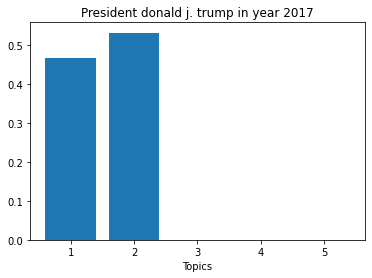

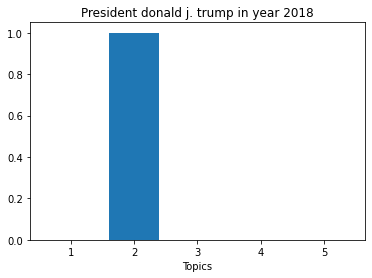

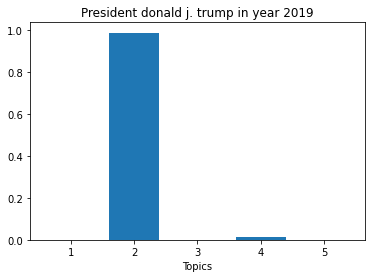

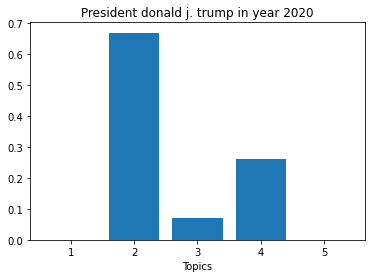

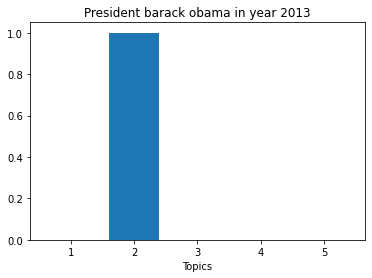

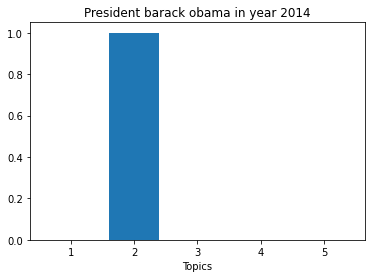

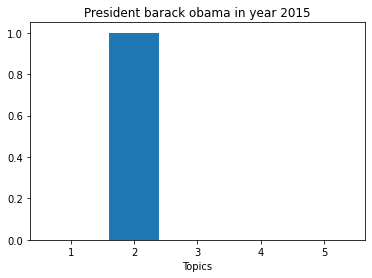

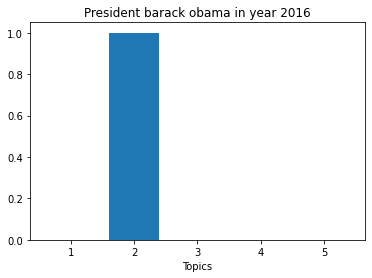

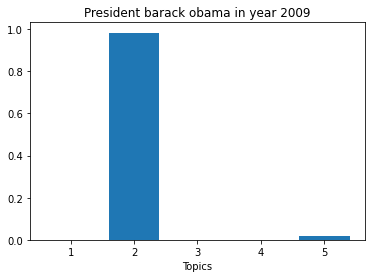

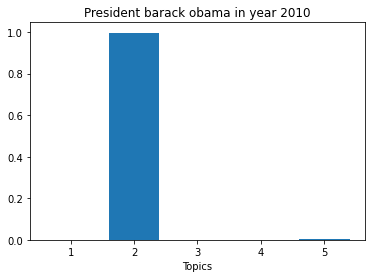

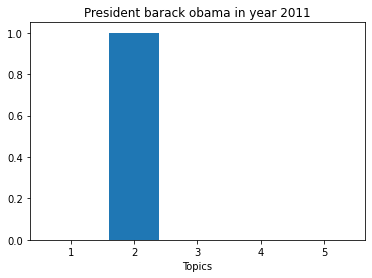

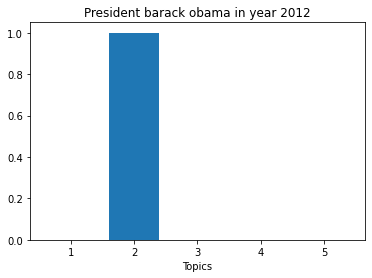

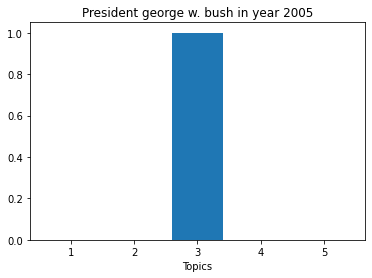

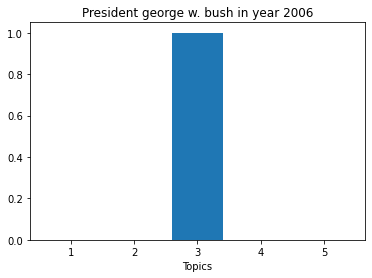

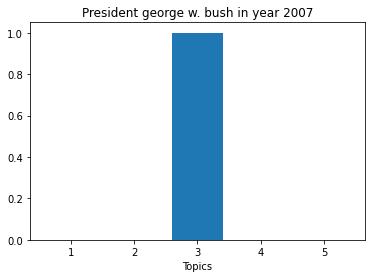

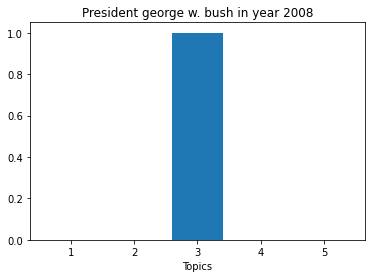

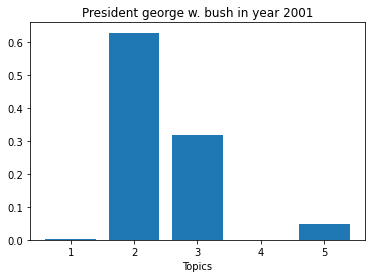

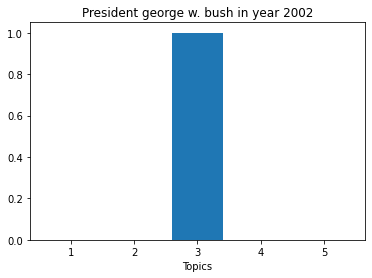

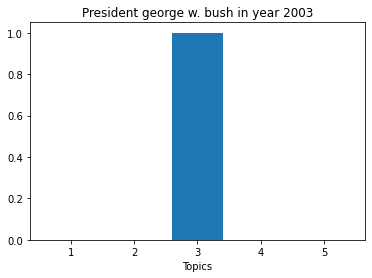

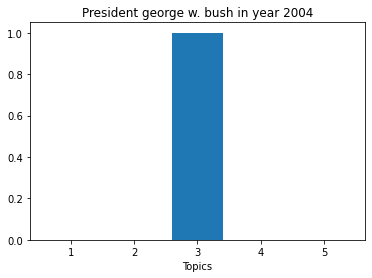

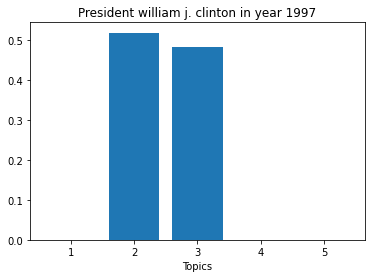

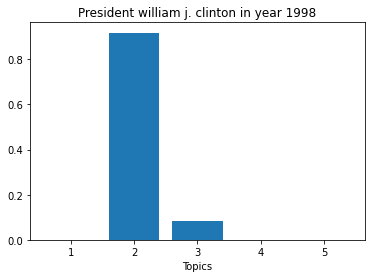

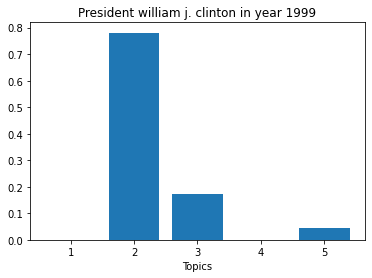

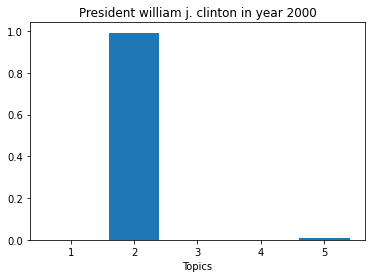

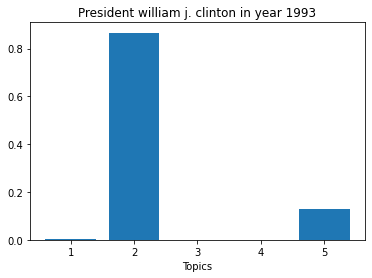

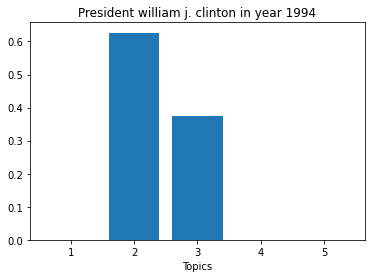

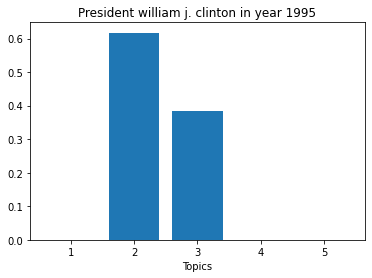

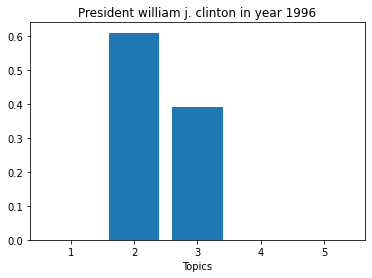

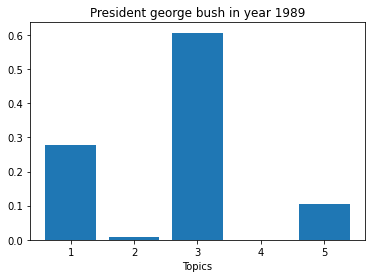

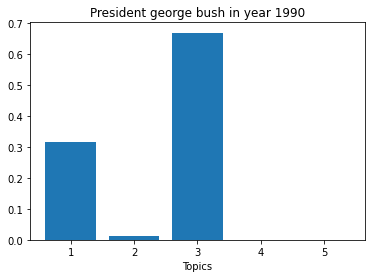

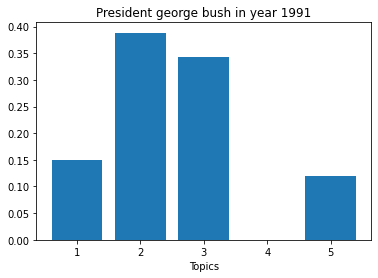

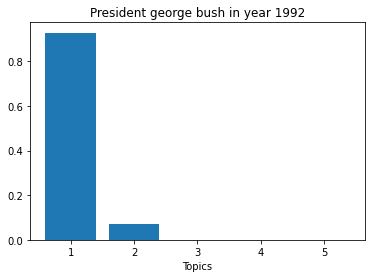

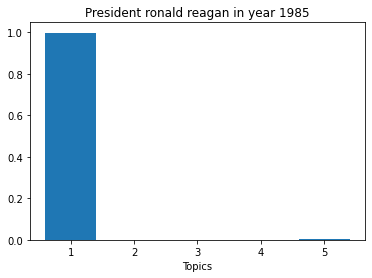

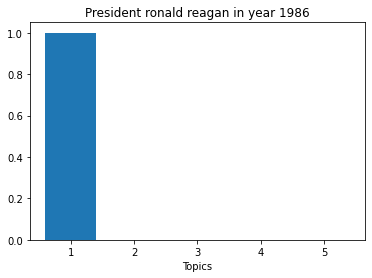

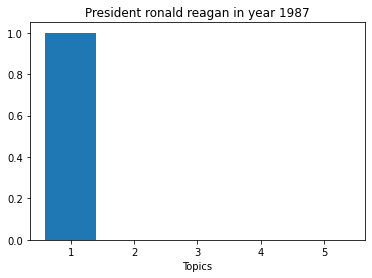

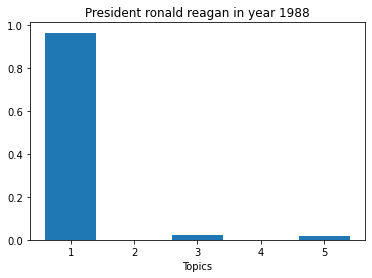

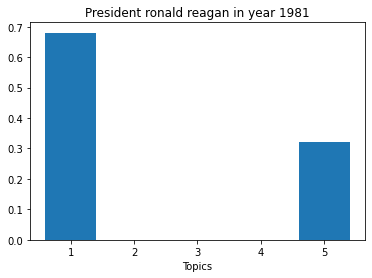

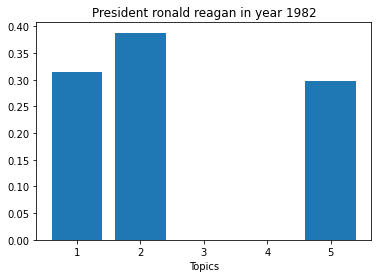

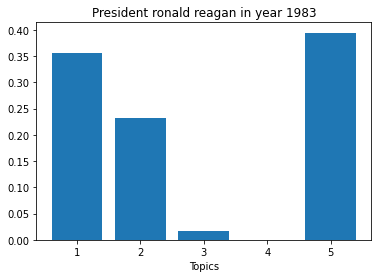

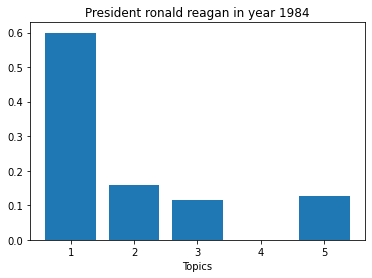

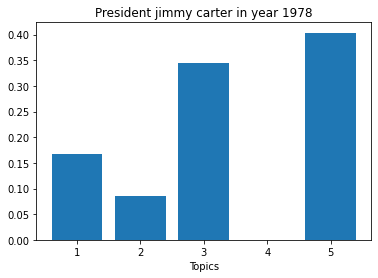

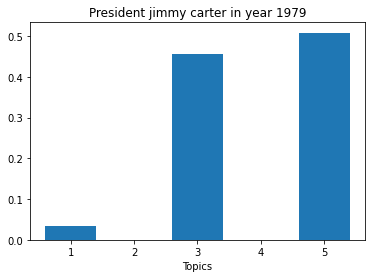

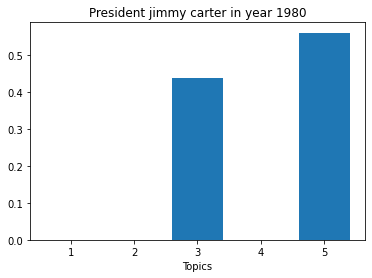

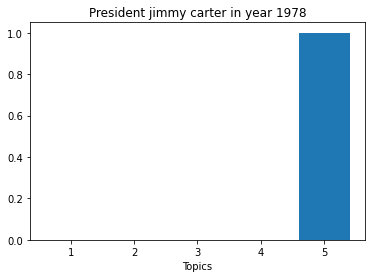

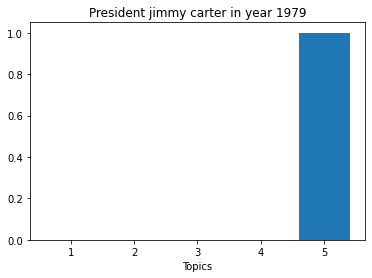

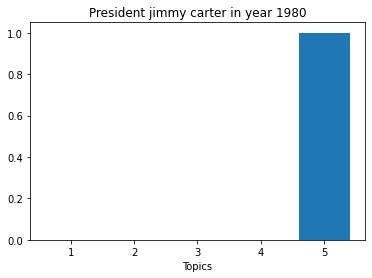

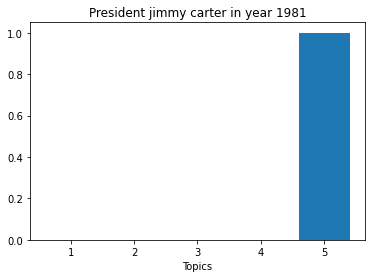

In [ ]:
# Plot each document (speech) in terms of distribution of topics
for i in range(0,speeches_df_filtered.shape[0]):
  plt.bar(np.arange(len(doc_topic_distribution[i]) + 1)[1:],
        doc_topic_distribution[i])
  plt.xlabel("Topics")
  plt.xticks(np.arange(len(doc_topic_distribution[i]) + 1)[1:])
  plt.title(f"President {speeches_df_filtered.iloc[i]['president']} in year {speeches_df_filtered.iloc[i]['year']}")
  plt.show()

### Partisanship
[Does the average proportion of health-related words differ between Republicans and Democrats?]  

In [ ]:
# Calculate proportions for each party for each president
republican_props_dict, democrat_props_dict = defaultdict(list), defaultdict(list)
for index, row in merged_df.iterrows():
  freq = 0
  for w in row['speech']:
    if w in health_dic:
      freq += 1
  
  prop = freq/len(row['speech'])
  democrat_props_dict[row['president']].append(prop) if row['is_democrat']=='True' else republican_props_dict[row['president']].append(prop)

# Average proportions for each president
republican_props, democrat_props = [], []
for president,props in republican_props_dict.items():
  avg_props = sum(props) / len(props)
  republican_props.append(avg_props)

for president,props in democrat_props_dict.items():
  avg_props = sum(props) / len(props)
  democrat_props.append(avg_props)

print(republican_props)
print(democrat_props)

[0.005335320485573067, 0.00908131660711962, 0.0030346125776392913, 0.002169828259294565]
[0.005524279304338175, 0.009207648206577483, 0.004876099154790502]


With sample sizes of 4 and 3 for republicans and democrats (respectively), there will be low statistical power and the normality assumption cannot be fulfilled. Moreover, speeches given by a certain president are not independent. Instead, we will run Friedman's test (see assumptions below). See [this document](https://www.statstutor.ac.uk/resources/uploaded/repeated-measures.pdf) for additional reference.  
  
  
This means that the question now shifts to the following...  
**[Is there a difference in the distributions of the proportion of health-reated words (for republicans and democrats) between a president's 1st, 2nd, 3rd, and 4th SOTUA?]**

In [ ]:
"""
ASSUMPTIONS:
1. Data is continuous
2. Data comes from a single group* (measured on at least 3 different occasions)
3. Group is random sample from population**
4. Observations are ranked within blocks with no ties

*In this case, the group is the SOTUA order (1st year, 2nd year, 3rd year, 4th year)
**Due to a lack of data, the group is representative of the population (there are only 4 speeches in each group) 

It should also be noted that a president serving two terms are treated as two distinct groups.
"""

# Recreate props dict for republicans and democrats but with strict group (speech) size of 4
"""
NOTE:
- data from Jimmy Carter's speeches are only available for his 2nd, 3rd, 4th, and end of 4th addresses -- we treat this as 1st, 2nd. 3rd 4th
- Jimmy Carter also has speech data from 1978 - 1980 but we skip these as this would form a group with 4 blocks
"""
seen_carter_years = []

# Sort merged_df to guarantee that we can separate a president's 1st and 2nd terms
sorted_merged_df = merged_df.sort_values(by='year')

republican_props_dict, democrat_props_dict = defaultdict(list), defaultdict(list)
for index, row in sorted_merged_df.iterrows():
  if row['president'] == 'jimmy carter':
    if row['year'] in seen_carter_years:
      # Duplicate Carter speech
      continue
    else:
      seen_carter_years.append(row['year'])


  freq = 0
  for w in row['speech']:
    if w in health_dic:
      freq += 1
  prop = freq/len(row['speech'])

  if len(democrat_props_dict[row['president']]) == 4 and row['is_democrat'] == 'True':
    # President is democrat and first term is already filled (with 4 speeches)
    democrat_props_dict[row['president']+'_2'].append(prop)
  elif len(republican_props_dict[row['president']]) == 4 and row['is_democrat']=='False':
    # President is republican and first term is already filled (with 4 speeches)
    republican_props_dict[row['president']+'_2'].append(prop)
  else:
    democrat_props_dict[row['president']].append(prop) if row['is_democrat']=='True' else republican_props_dict[row['president']].append(prop)

# Filter out empty lists in both dicts
clean_republican_props_dict, clean_democrat_props_dict = {}, {}
for k,v in republican_props_dict.items():
  if len(v) != 0:
    clean_republican_props_dict[k] = v
for k,v in democrat_props_dict.items():
  if len(v) != 0:
    clean_democrat_props_dict[k] = v

# print(clean_republican_props_dict)
# print(clean_democrat_props_dict)

# Run Friedman's test on Republicans and Democrats
alpha = 0.05
rep_stat, rep_p = friedmanchisquare(*clean_republican_props_dict.values())
dem_stat, dem_p = friedmanchisquare(*clean_democrat_props_dict.values())

print(rep_p)
print(dem_p)

if rep_p < alpha:
  print("We reject the null that there is no difference between the population distributions of the year a Republican president gave a SOTUA.")
else:
  print("We fail to reject the null that there is no difference between the population distributions of the year a Republican president gave a SOTUA.")

if dem_p < alpha:
  print("We reject the null that there is no difference between the population distributions of the year a Democrat president gave a SOTUA.")
else:
  print("We fail to reject the null that there is no difference between the population distributions of the year a Democrat president gave a SOTUA.")

0.017529879802988126
0.2145905582199873
We reject the null that there is no difference between the population distributions of the year a Republican president gave a SOTUA.
We fail to reject the null that there is no difference between the population distributions of the year a Democrat president gave a SOTUA.


### Frequency of keywords
[Is there a relationship between frequency of health-related words and percentage spend on the health department?]


Loading the health related words dictionary 

Finds the frequency of health_dic words per year

In [ ]:
def create_data_df(raw_set):
  frequencies = []
  for speech in raw_set["speech"]:
    freq = 0
    for word in speech:
      if word in health_dic:
        freq += 1
    frequencies.append(freq / len(speech))
  data = raw_set.copy()
  data['freq'] = frequencies
  
  # Fixes datatype issues
  data['freq'] = pd.to_numeric(data['freq'])
  data['year'] = pd.to_numeric(data['year'])
  data['% spent'] = pd.to_numeric(data['percent health budget spend'])
  data['is_dem'] = data["is_democrat"].apply(lambda x: x == "True")

  data.drop(['url', 'speech', 'percent health budget spend', "is_democrat"], 
            axis=1, inplace=True)
  return data

test_data = create_data_df(test_set)
train_data = create_data_df(train_set)
all_data = test_data.append(train_data)
all_data

,president,year,freq,% spent,is_dem
9,barack obama,2010,0.007983,0.255297,True
1,donald j. trump,2018,0.002602,0.263421,False
31,george bush,1992,0.006391,0.171351,False
15,george w. bush,2008,0.005017,0.216967,False
43,jimmy carter,1979,0.005251,0.106877,True
34,ronald reagan,1987,0.002443,0.129179,False
24,william j. clinton,1993,0.010120,0.174792,True
40,ronald reagan,1984,0.001303,0.112321,False
40,ronald reagan,1984,0.001303,0.112321,False
37,jimmy carter,1981,0.005141,0.109129,True


####Exploratory Graphs

In [ ]:
# General Plotting function

# chages color of scatter points based on president 
def get_colors(row):
  COLORS = {
      "donald j. trump": "#882255",
      "barack obama": "#88ccee",
      "george w. bush": "#CC6677",
      "william j. clinton": "#44AA99",
      "george bush": "#AA4499",
      "ronald reagan": "#33228B",
      "jimmy carter": "#117733"
  }
  return COLORS[row['president']]

# changes marker symbol based on partisanship
def get_marker(row):
  return "*" if row["is_dem"] else "p"

def plot_items(x_var, y_var, ax):
  labeled = {
        "donald j. trump": False,
        "barack obama": False,
        "george w. bush": False,
        "william j. clinton": False,
        "george bush": False,
        "ronald reagan": False,
        "jimmy carter": False
    }

  # graph frequencies vs year
  for _, row in all_data.iterrows():
      prez = row['president']
      ax.scatter(row[x_var], row[y_var], s=90, c=get_colors(row), 
                  marker=get_marker(row), alpha=1,
                  label=prez if not labeled[prez] else None)
      labeled[prez] = True


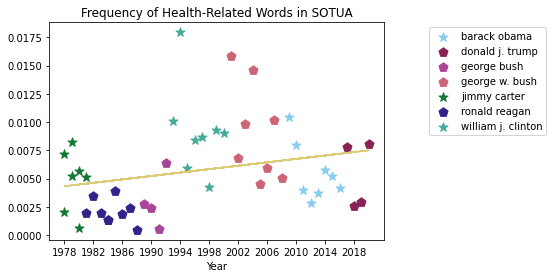

In [ ]:
# Change in healthcare mentions over time
fig, ax = plt.subplots()

plot_items('year', 'freq', ax)
ax.set_xlabel("Year")
ax.set_title("Frequency of Health-Related Words in SOTUA")
ax.set_xticks(range(min(all_data["year"]), max(all_data["year"]) + 1, 4))

# brief linear regression to show general pattern
m, b = np.polyfit(all_data["year"], all_data["freq"], 1)
ax.plot(all_data["year"], m*all_data["year"]+b, color='#DDCC77')
ax.legend(bbox_to_anchor=(1.5, 1))

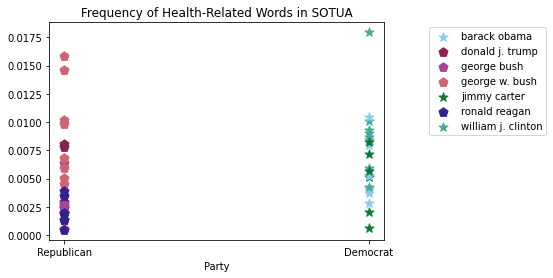

In [ ]:
# Healthcare mentions compared by partisanship

fig, ax = plt.subplots()
plot_items('is_dem', 'freq', ax)
ax.set_title("Frequency of Health-Related Words in SOTUA")
ax.set_xlabel("Party")
ax.set_xticks([0, 1])
ax.set_xticklabels(['Republican', 'Democrat'])
ax.legend(bbox_to_anchor=(1.5, 1))

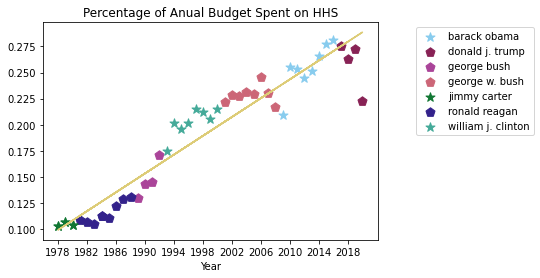

In [ ]:
# graph frequencies of healthcare terms vs year
fig, ax = plt.subplots()
plot_items('year', '% spent', ax)
ax.set_xlabel("Year")
ax.set_title("Percentage of Anual Budget Spent on HHS")
ax.set_xticks(range(min(all_data["year"]), max(all_data["year"]) + 1, 4))

# brief linear regression to show general pattern
m, b = np.polyfit(all_data["year"], all_data["% spent"], 1)
ax.plot(all_data["year"], m*all_data["year"]+b, color='#DDCC77')
ax.legend(bbox_to_anchor=(1.1, 1))

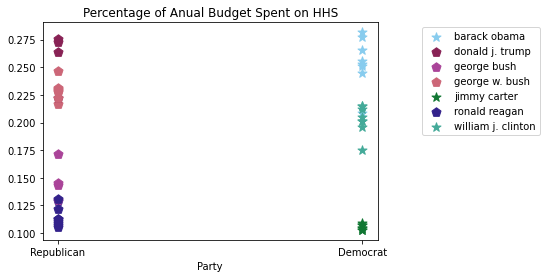

In [ ]:
# compares partisanship and healthcare spending
fig, ax = plt.subplots()
plot_items('is_dem', '% spent', ax)
ax.set_title("Percentage of Anual Budget Spent on HHS")
ax.set_xlabel("Party")
ax.set_xticks([0, 1])
ax.set_xticklabels(['Republican', 'Democrat'])
ax.legend(bbox_to_anchor=(1.5, 1))

#### Standard regression


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa1de25ac90>)

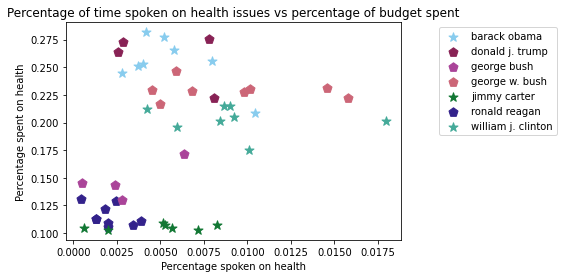

In [ ]:
# Plots all the data points on a healthcare word frequency vs spending plot
def scatter_plot():
  fig, ax = plt.subplots()

  # plots percent spent and percent spoken on health

  plot_items("freq", "% spent", ax)

  ax.set_title("Percentage of time spoken on health issues vs percentage of budget spent")
  ax.set_ylabel("Percentage spent on health")
  ax.set_xlabel("Percentage spoken on health")

  ax.legend(bbox_to_anchor=(1.1, 1))

  return fig, ax

scatter_plot()

                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     5.353
Date:                Tue, 27 Jul 2021   Prob (F-statistic):             0.0265
Time:                        19:51:27   Log-Likelihood:                 54.950
No. Observations:                  38   AIC:                            -105.9
Df Residuals:                      36   BIC:                            -102.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1582      0.017      9.360      0.0

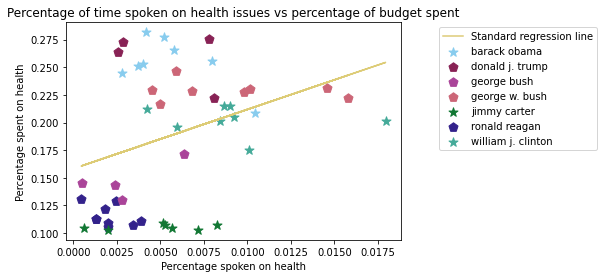

In [ ]:
# linear regression

def run_regression(train_data, test_data):
  X = sm.add_constant(train_data['freq'])
  y = train_data['% spent']

  model = sm.OLS(y, X).fit()

  print(model.summary())
  print(f" - MSE Training:{eval_measures.mse(y, model.predict(X))}")

  def get_x():
    if len(test_data['freq']) > 1:
      return sm.add_constant(test_data['freq'])
    else:
      test_data['const'] = [1]
      return test_data[['const', 'freq']]

  mse_test = eval_measures.mse(test_data['% spent'], 
                               model.predict(get_x()))
  
  print(f" - MSE Testing: {mse_test}")
  return model

fig, ax = scatter_plot()

model = run_regression(train_data, test_data)
ax.plot(all_data['freq'], model.predict(sm.add_constant(all_data['freq'])),
        color='#DDCC77', label='Standard regression line')
ax.legend(bbox_to_anchor=(1.1, 1))

Noticibly, the data divides into clusters before and after clinton. Thus, we decided to run regression by cluster to avoid simpsons paradox. We give the following justification
1. Clinton's Health Security Act healthcare reform push in 1993 most likely introduced tons of healthcare vocabulary into mainstream discourse, whereas there was never that large of an emphasis on healthcare before him. Many words from our dictionary were most likely unwittingly influenced by Clinton.
2. There was a sizable spike in the 90s in healthcare spending
3. Health care prices accelerated in the 90s, becoming double the rate of inflation.

#### Pre - post Clinton cluster Split regression

In [ ]:
# Splits

POST_CLINTON_PREZ = ["donald j. trump", "barack obama", "george w. bush", "william j. clinton"]

pre_clinton_test = test_data[~test_data['president'].isin(POST_CLINTON_PREZ)]
post_clinton_test = test_data[test_data['president'].isin(POST_CLINTON_PREZ)]

pre_clinton_train = train_data[~train_data['president'].isin(POST_CLINTON_PREZ)]
post_clinton_train = train_data[train_data['president'].isin(POST_CLINTON_PREZ)]

print(pre_clinton_test.shape)
print(pre_clinton_train.shape)
print(post_clinton_test.shape)
print(post_clinton_train.shape)

(6, 5)
(14, 5)
(4, 5)
(24, 5)


=== PRE CLINTON ===
                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     3.155
Date:                Tue, 27 Jul 2021   Prob (F-statistic):              0.101
Time:                        19:51:34   Log-Likelihood:                 40.853
No. Observations:                  14   AIC:                            -77.71
Df Residuals:                      12   BIC:                            -76.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1249      0.006

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


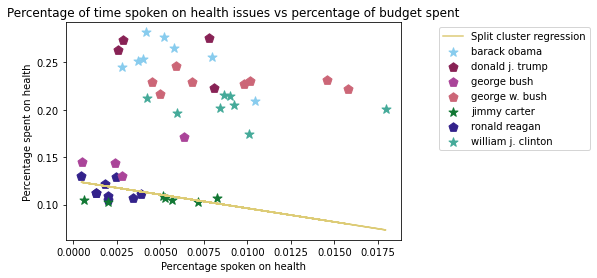

In [ ]:
print("=== PRE CLINTON ===")
model = run_regression(pre_clinton_train, pre_clinton_test)

fig, ax = scatter_plot()

ax.plot(all_data['freq'], model.predict(sm.add_constant(all_data['freq'])), 
                    color='#DDCC77', label='Split cluster regression')
ax.legend(bbox_to_anchor=(1.1, 1))

=== POST CLINTON ===
                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     7.681
Date:                Tue, 27 Jul 2021   Prob (F-statistic):             0.0111
Time:                        19:51:37   Log-Likelihood:                 57.385
No. Observations:                  24   AIC:                            -110.8
Df Residuals:                      22   BIC:                            -108.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2598      0.01

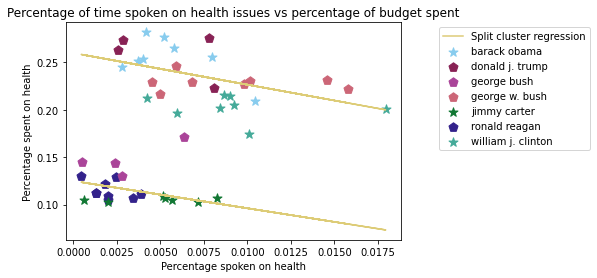

In [ ]:
print("=== POST CLINTON ===")
model = run_regression(post_clinton_train, post_clinton_test)

ax.plot(all_data['freq'], model.predict(sm.add_constant(all_data['freq'])), 
        color='#DDCC77')
fig

#### Split by each president

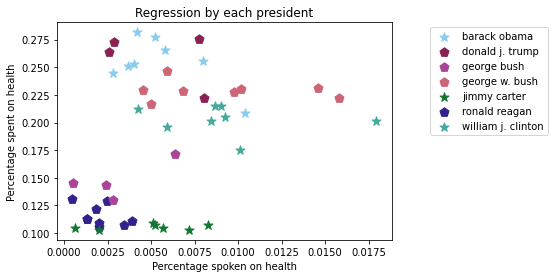

In [ ]:
all_fig, all_ax = scatter_plot()
all_ax.set_title("Regression by each president")

prez_coeff = {"president" : [], "coeff": []}

def presidential_regression(name):
  test_prez = test_data[test_data['president'] == name]
  train_prez = train_data[train_data['president'] == name]

  model = run_regression(train_prez, test_prez)

  all_ax.plot(all_data['freq'], model.predict(sm.add_constant(all_data['freq'])),
          color=COLORS[name])
  prez_coeff["president"].append(name)
  prez_coeff["coeff"].append(model.params[1])
  
  fig_prez, ax_prez = scatter_plot()
  ax_prez.plot(all_data['freq'], model.predict(sm.add_constant(all_data['freq'])),
               color=COLORS[name])
  ax_prez.set_title(f"Regression - {name}")
  fig_prez.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                 -0.106
Method:                 Least Squares   F-statistic:                    0.6151
Date:                Tue, 27 Jul 2021   Prob (F-statistic):              0.490
Time:                        20:18:39   Log-Likelihood:                 25.952
No. Observations:                   5   AIC:                            -47.90
Df Residuals:                       3   BIC:                            -48.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1033      0.001     70.094      0.0

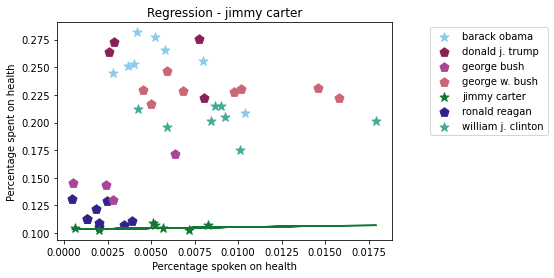

In [ ]:
#Jimmy Carter Regression
presidential_regression("jimmy carter")

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     3.731
Date:                Tue, 27 Jul 2021   Prob (F-statistic):              0.126
Time:                        20:19:29   Log-Likelihood:                 21.675
No. Observations:                   6   AIC:                            -39.35
Df Residuals:                       4   BIC:                            -39.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1267      0.007     17.310      0.0

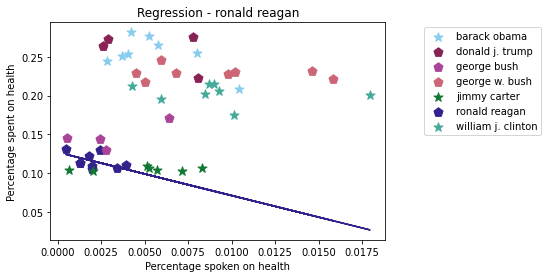

In [ ]:
presidential_regression("ronald reagan")

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.9614
Date:                Tue, 27 Jul 2021   Prob (F-statistic):              0.506
Time:                        20:20:14   Log-Likelihood:                 11.648
No. Observations:                   3   AIC:                            -19.30
Df Residuals:                       1   BIC:                            -21.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1490      0.011     13.732      0.0

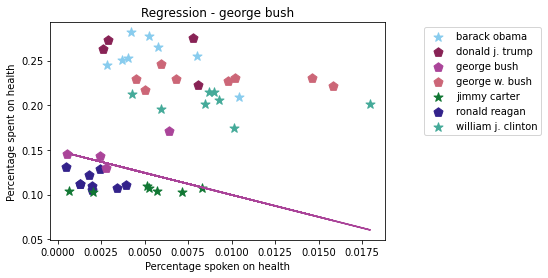

In [ ]:
presidential_regression("george bush")

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                 -0.140
Method:                 Least Squares   F-statistic:                    0.2611
Date:                Tue, 27 Jul 2021   Prob (F-statistic):              0.631
Time:                        20:20:50   Log-Likelihood:                 24.973
No. Observations:                   7   AIC:                            -45.95
Df Residuals:                       5   BIC:                            -46.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2102      0.008     27.790      0.0

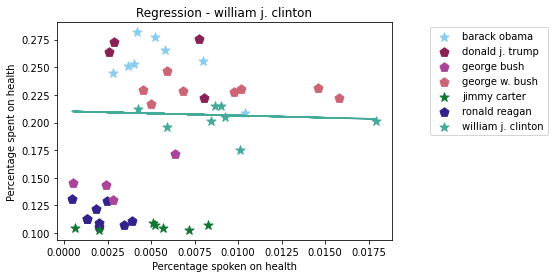

In [ ]:
presidential_regression("william j. clinton")

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     1.722
Date:                Tue, 27 Jul 2021   Prob (F-statistic):              0.246
Time:                        20:21:17   Log-Likelihood:                 25.893
No. Observations:                   7   AIC:                            -47.79
Df Residuals:                       5   BIC:                            -47.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2391      0.007     33.995      0.0

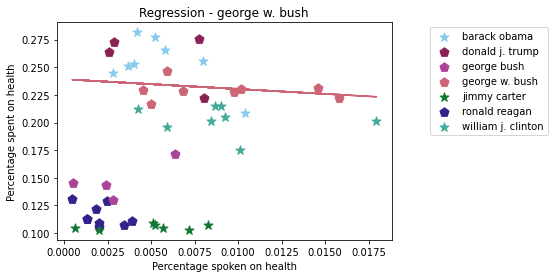

In [ ]:
presidential_regression("george w. bush")

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     3.115
Date:                Tue, 27 Jul 2021   Prob (F-statistic):              0.138
Time:                        20:22:03   Log-Likelihood:                 18.306
No. Observations:                   7   AIC:                            -32.61
Df Residuals:                       5   BIC:                            -32.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2856      0.019     14.803      0.0

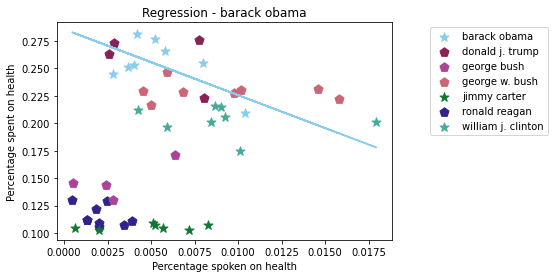

In [ ]:
presidential_regression("barack obama")

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


                            OLS Regression Results                            
Dep. Variable:                % spent   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                 -0.483
Method:                 Least Squares   F-statistic:                    0.3482
Date:                Tue, 27 Jul 2021   Prob (F-statistic):              0.661
Time:                        20:22:38   Log-Likelihood:                 7.3328
No. Observations:                   3   AIC:                            -10.67
Df Residuals:                       1   BIC:                            -12.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2896      0.059      4.902      0.1

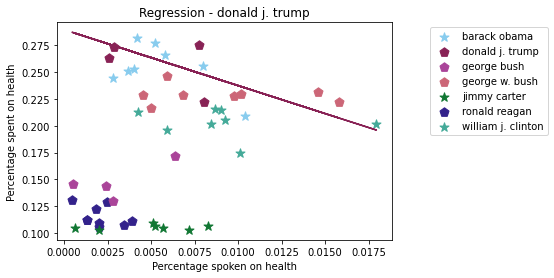

In [ ]:
presidential_regression("donald j. trump")

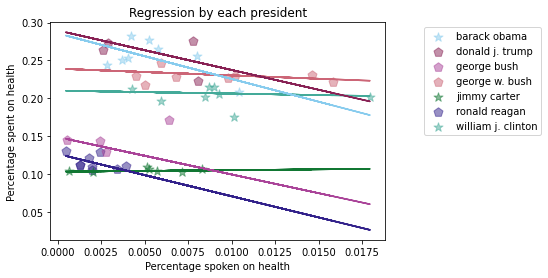

In [ ]:
all_fig



Text(0, 0.5, 'Coefficient')

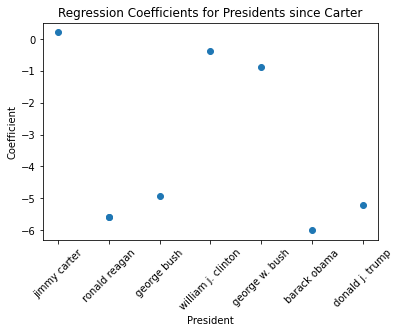

In [ ]:
plt.plot(prez_coeff["president"], prez_coeff["coeff"], "o")
plt.xticks(rotation=45)
plt.title("Regression Coefficients for Presidents since Carter")
plt.xlabel("President")
plt.ylabel("Coefficient")

### Bag of Words

In [ ]:
# print(speeches_df_filtered["speech"].get(0))
word_freq_by_speech = {}
for speech_ind in range(1, len(speeches_df_filtered)):
  word_freq = {}
  curr_speech = speeches_df_filtered["year"].get(speech_ind)
  # print(curr_speech)
  word_freq_by_speech[curr_speech] = word_freq
  just_speech = speeches_df_filtered["speech"].get(speech_ind)
  # print(type(just_speech))
  # print(just_speeches)
  for word in just_speech:
    if word in word_freq.keys():
      word_freq[word] += 1
    else:
      word_freq[word] = 1


In [ ]:
# for entry in word_freq_by_speech:
#   word_freq_by_speech[entry] = sorted(word_freq_by_speech[entry])
print( word_freq_by_speech)

{'2017': {'thank': 18, 'speaker': 4, 'vice': 4, 'president': 12, 'members': 4, 'congress': 18, 'lady': 2, 'united': 26, 'states': 24, 'citizen': 22, 'tonight': 26, 'mark': 2, 'conclusion': 2, 'celebration': 4, 'black': 2, 'history': 10, 'month': 6, 'remind': 4, 'nation': 42, 'path': 4, 'civil': 4, 'right': 22, 'work': 24, 'remain': 2, 'recent': 4, 'threat': 2, 'target': 2, 'jewish': 4, 'community': 12, 'center': 8, 'vandalism': 2, 'cemetery': 2, 'week': 2, 'shooting': 2, 'kansas': 2, 'city': 8, 'divide': 2, 'policy': 8, 'country': 52, 'stand': 2, 'condemn': 2, 'hate': 2, 'evil': 2, 'ugly': 2, 'form': 8, 'generation': 2, 'pass': 4, 'torch': 4, 'truth': 2, 'liberty': 2, 'justice': 14, 'unbroken': 2, 'chain': 2, 'way': 8, 'present': 2, 'hand': 2, 'use': 4, 'light': 4, 'world': 36, 'deliver': 8, 'message': 4, 'unity': 2, 'strength': 2, 'deeply': 2, 'heart': 4, 'new': 38, 'chapter': 4, 'greatness': 4, 'begin': 12, 'national': 18, 'pride': 2, 'sweep': 2, 'surge': 2, 'optimism': 2, 'place': 8